In [172]:
import pandas as pd
pd.set_option("mode.copy_on_write", True)
import geopandas as gpd
import fiona
import os
import matplotlib.pyplot as plt
from shapely.ops import nearest_points
from shapely import wkt
import shapely.wkt

import numpy as np
import pandas as pd
pd.set_option("mode.copy_on_write", True)
import geopandas as gpd
import fiona
import os
import matplotlib.pyplot as plt
from shapely.ops import nearest_points




In [173]:
######################################################################
# LOAD FIRE DATA AND DEMOGRAPHIC DATA
######################################################################

demographic_data = pd.read_csv("../10_Data_Clean/demographic_data.csv", dtype={'GEO_UNIQUE_ID': str})

final_fire_data = pd.read_csv('../10_Data_Clean/final_fire_data.csv', dtype={'GEO_UNIQUE_ID': str})

final_census_shapefile = gpd.read_file("../10_Data_Clean/final_census_shapefile.shp") 


In [174]:
demographic_data.shape

(82572, 15)

In [175]:
final_fire_data.head()

,GEO_UNIQUE_ID,YEAR,NUM_FIRES,TOTAL_AREA_BURNED_IN_M2,AVG_FIRE_DURATION_DAYS,MAX_PCT_TRACT_BURNED
0,001435103,2020,1,30.44,26.00,0.00
1,001450601,2020,1,83396.14,26.00,0.17
2,001450701,2020,1,46920629.40,26.00,17.81
3,003010000,2012,1,587502.93,6.00,0.03
4,003010000,2014,1,381280.97,9.00,0.02


In [176]:
######################################################################
# MAKE SURE ALL GEO_UNQIUE_ID ARE LOADED PROPELRY
######################################################################

# Create length column
final_fire_data['GEO_ID_LENGTH'] = final_fire_data['GEO_UNIQUE_ID'].str.len() # Make sure it's string first

# Show how many have each length
print("final_fire_data lengths:")
print(final_fire_data['GEO_ID_LENGTH'].value_counts())

# Create length column
demographic_data['GEO_ID_LENGTH'] = demographic_data['GEO_UNIQUE_ID'].str.len() # Make sure it's string first

# Show how many have each length
print("demographic_data lengths:")
print(demographic_data['GEO_ID_LENGTH'].value_counts())

final_fire_data lengths:
GEO_ID_LENGTH
9    1396
Name: count, dtype: int64
demographic_data lengths:
GEO_ID_LENGTH
9    82572
Name: count, dtype: int64


In [177]:
######################################################################
# MERGE FIRE DATA AND DEMOGRAPHIC DATA
######################################################################

merged_data = pd.merge(
    demographic_data,
    final_fire_data,
    left_on=["GEO_UNIQUE_ID", "YEAR"],
    right_on=["GEO_UNIQUE_ID", "YEAR"],
    how="left",
    indicator=True
)
print(merged_data.shape)
print(merged_data["_merge"].value_counts())

# CHECK WHAT DID NOT MATCH: NB ECERYTHING SHOULD HAVE MATCHED
unmatched_tracks = final_fire_data.loc[
    ~final_fire_data["GEO_UNIQUE_ID"].isin(demographic_data["GEO_UNIQUE_ID"].unique()),
    "GEO_UNIQUE_ID"
].value_counts()

unmatched_tracks # 14 tracks  aren't included in demographic dataset 
# those track ZIPs’ rows in the fire data are dropped in the final merge result, because we're joining from demographic tracks only (left join), and those 14 tracks don’t exist there.


(82572, 22)
_merge
left_only     81176
both           1396
right_only        0
Name: count, dtype: int64


Series([], Name: count, dtype: int64)

In [178]:
final_census_shapefile.head()

final_census_shapefile["GEO_UNIQUE_ID"] = final_census_shapefile["COUNTYFP"] + final_census_shapefile["TRACTCE"]

final_census_shapefile.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,GEO_UNIQUE,geometry,GEO_UNIQUE_ID
0,06,029,004402,06029004402,44.02,Census Tract 44.02,G5020,S,1865739,0,+35.5917343,-119.3337642,029004402,"POLYGON ((59906.842 -270407.558, 59906.948 -27...",029004402
1,06,047,000802,06047000802,8.02,Census Tract 8.02,G5020,S,2321653,0,+37.3433591,-120.5854604,047000802,"POLYGON ((-52727.332 -74888.681, -52723.908 -7...",047000802
2,06,085,501402,06085501402,5014.02,Census Tract 5014.02,G5020,S,522620,0,+37.3453341,-121.8665169,085501402,"POLYGON ((-165759.786 -73091.934, -165741.347 ...",085501402
3,06,005,000102,06005000102,1.02,Census Tract 1.02,G5020,S,456204155,7940832,+38.5496993,-120.2509786,005000102,"POLYGON ((-53212.46 44552.019, -53197.688 4457...",005000102
4,06,029,004901,06029004901,49.01,Census Tract 49.01,G5020,S,1459379,0,+35.7837173,-119.2462266,029004901,"POLYGON ((67478.588 -247133.459, 67482.018 -24...",029004901


In [179]:
# Make sure both sides have GEO_UNIQUE_ID as string
final_census_shapefile["GEO_UNIQUE_ID"] = final_census_shapefile["GEO_UNIQUE_ID"].astype(str)
merged_data["GEO_UNIQUE_ID"] = merged_data["GEO_UNIQUE_ID"].astype(str)


merged_data = merged_data.merge(
    final_census_shapefile[["GEO_UNIQUE_ID", "geometry"]],
    on="GEO_UNIQUE_ID",
    how="left"
)


In [180]:
# CHECK WHAT DID NOT MATCH: NB ECERYTHING SHOULD HAVE MATCHED
unmatched_tracks = final_fire_data.loc[
    ~final_fire_data["GEO_UNIQUE_ID"].isin(demographic_data["GEO_UNIQUE_ID"].unique()),
    "GEO_UNIQUE_ID"
].value_counts()

unmatched_tracks # 14 tracks  aren't included in demographic dataset 
# those track ZIPs’ rows in the fire data are dropped in the final merge result, because we're joining from demographic tracks only (left join), and those 14 tracks don’t exist there.

Series([], Name: count, dtype: int64)

In [181]:
######################################################################
# CREATE A FLAG FOR FIRE EXPOSURE
######################################################################
# 0 means area was NOT exposed to fire that year
# 1 means yes
merged_data["FIRE_EXPOSED"] = (merged_data["_merge"] == "both").astype(int)
merged_data.shape

(82572, 24)

In [182]:
merged_data.columns

Index(['Median_Household_Income', 'Total_Population', 'PRICE',
       'Avg_Household_Size', 'Gini_Index', 'YEAR', 'GEO_UNIQUE_ID',
       'Employment_Rate', 'Below_Poverty_Rate', 'Rate_College_or_Higher',
       'Black_Portion', 'White_Portion',
       'American_Indian_and_Alaska_Native_Portion', 'Asian_Portion',
       'INCOMExRACE', 'GEO_ID_LENGTH_x', 'NUM_FIRES',
       'TOTAL_AREA_BURNED_IN_M2', 'AVG_FIRE_DURATION_DAYS',
       'MAX_PCT_TRACT_BURNED', 'GEO_ID_LENGTH_y', '_merge', 'geometry',
       'FIRE_EXPOSED'],
      dtype='object')

In [183]:
######################################################################
# CREATE TARGET VALUE: PCT_PRICE_CHANGE 
######################################################################

#######  Create Target Value: PCT_PRICE_CHANGE ###########

# Step 1: Sort by ZIP and Year
merged_data = merged_data.sort_values(by=["GEO_UNIQUE_ID", "YEAR"])

# Step 2: Compute next year’s median home value per tracts: DO NOT INCLUDE THIS IN XGBOOST
merged_data["NEXT_YEAR_PRICE"] = (
    merged_data.groupby("GEO_UNIQUE_ID")["PRICE"].shift(-1)
)

# Step 3: Compute price change: DO NOT INCLUDE THIS IN XGBOOST
merged_data["PRICE_CHANGE"] = (
    merged_data["NEXT_YEAR_PRICE"] - merged_data["PRICE"]
)

# Step 4: Compute percent price change
merged_data["PCT_PRICE_CHANGE (%)"] = (
    merged_data["PRICE_CHANGE"] / merged_data["PRICE"]
) * 100

# Step 5: Drop rows where the percent change can't be calculated (e.g., final year)
merged_data = merged_data.dropna(subset=["PCT_PRICE_CHANGE (%)"])

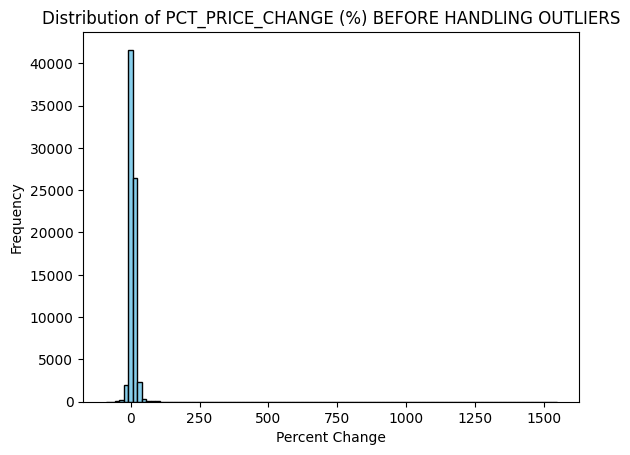

Largest % increases:
8309    1546.16
8168     581.07
11627    253.36
12964    160.74
42477    156.73
Name: PCT_PRICE_CHANGE (%), dtype: float64

Largest % decreases:
4363    -90.92
10892   -89.89
11251   -73.60
5431    -68.12
49248   -64.08
Name: PCT_PRICE_CHANGE (%), dtype: float64
Numbers of extreme outliers in price change: 3


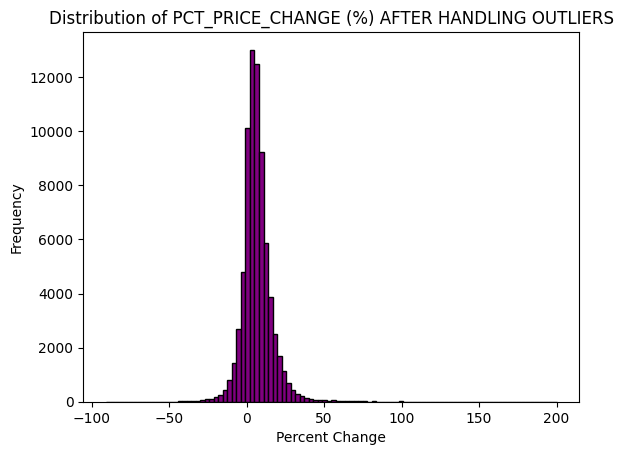

In [184]:
######################################################################
# HADNLE OUTLIERS IN PRICE CHANGE
######################################################################

import matplotlib.pyplot as plt

# Histogram of PCT_PRICE_CHANGE (%) with all values
plt.hist(merged_data["PCT_PRICE_CHANGE (%)"], bins=100, color='skyblue', edgecolor='black')
plt.title("Distribution of PCT_PRICE_CHANGE (%) BEFORE HANDLING OUTLIERS")
plt.xlabel("Percent Change")
plt.ylabel("Frequency")
plt.show()


# Show the top 5 highest % changes
print("Largest % increases:")
print(merged_data["PCT_PRICE_CHANGE (%)"].sort_values(ascending=False).head())

# Show the bottom 5 lowest % changes
print("\nLargest % decreases:")
print(merged_data["PCT_PRICE_CHANGE (%)"].sort_values().head())

# Define a reasonable threshold (e.g., anything > 200% or < -200%)
threshold = 200

# Subset rows where the percent change is extreme
extreme_outliers = merged_data[
    (merged_data["PCT_PRICE_CHANGE (%)"] > threshold) |
    (merged_data["PCT_PRICE_CHANGE (%)"] < -threshold)
]

# Display
pd.set_option("display.float_format", lambda x: f"{x:.2f}")
extreme_outliers_sorted = extreme_outliers.sort_values("PCT_PRICE_CHANGE (%)", ascending=False)

print(f"Numbers of extreme outliers in price change: {extreme_outliers_sorted.shape[0]}")

# Clip the price change
merged_data["PCT_PRICE_CHANGE (%)"] = merged_data["PCT_PRICE_CHANGE (%)"].clip(lower=-threshold, upper=threshold)

# Histogram of PCT_PRICE_CHANGE (%) with all values
plt.hist(merged_data["PCT_PRICE_CHANGE (%)"], bins=100, color='purple', edgecolor='black')
plt.title("Distribution of PCT_PRICE_CHANGE (%) AFTER HANDLING OUTLIERS")
plt.xlabel("Percent Change")
plt.ylabel("Frequency")
plt.show()


In [185]:
######################################################################
# FEATURE ENGINEERING: ADDING TIME SERIES & FIRE FEATURE & INTERACTION TERMS TO IMPROVE MODEL
######################################################################

# Adding features

# Rolling averages (commenting them out cause we lose to much data)
# Rolling average of price change over the last 1 year (excluding current)
merged_data["ROLLING_1yr_PRICE_CHANGE"] = merged_data.groupby("GEO_UNIQUE_ID")["PCT_PRICE_CHANGE (%)"].shift(1).rolling(1).mean()
# Rolling average of price change over the last 2 years (excluding current): Smooths short-term volatility to identify trends
#df["ROLLING_2yr_PRICE_CHANGE"] = df.groupby("ZipCode")["PCT_PRICE_CHANGE (%)"].shift(1).rolling(2).mean() we lose too much data

# Lag price-related features: THOSE FEATURES DO NOT LEAK FUTURE VALUE INTO XGBOOST ==> SAFE
merged_data['HOME_PRICE_LAG1'] = merged_data.groupby('GEO_UNIQUE_ID')['PRICE'].shift(1)
merged_data['PRICE_CHANGE_LAG1'] = merged_data.groupby('GEO_UNIQUE_ID')['PRICE_CHANGE'].shift(1)
merged_data['PRICE_CHANGE_DIFF'] = merged_data['PRICE_CHANGE'] - merged_data['PRICE_CHANGE_LAG1']

# What it is: Max % of ZIP burned from the previous year.
# Why: Fires may have a lagged effect on market prices — impact might show up the year after.
merged_data['PREV_MAX_PCT_TRACT_BURNED'] = merged_data.groupby('GEO_UNIQUE_ID')['MAX_PCT_TRACT_BURNED'].shift(1)

# Create indicator for ANY_MAJOR_FIRE
merged_data['ANY_MAJOR_FIRE'] = (
    (merged_data['MAX_PCT_TRACT_BURNED'] > 10) |  # per guidelines
    (merged_data['AVG_FIRE_DURATION_DAYS'] > 14) # per guidelines
).astype(int)

# Post-fire year: fire happened in the previous year
merged_data['FIRE_LAST_YEAR'] = merged_data.groupby('GEO_UNIQUE_ID')['ANY_MAJOR_FIRE'].shift(1).fillna(0).astype(int)

# Fire shock indicator: 1 if ZIP had 2+ fires in a year (unusually high fire activity).
# Based on domain logic and histogram — most ZIP-years have 0–1 fire, so 2+ is a meaningful threshold.
merged_data['FIRE_SHOCK'] = (merged_data['NUM_FIRES'] >= 2).astype(int)


# Other Features Skye added

# Calculate YEAR_OF_LAST_FIRE for each ZIP
merged_data['YEAR_OF_LAST_FIRE'] = (
    merged_data
    .loc[merged_data['FIRE_EXPOSED'] == 1]
    .groupby('GEO_UNIQUE_ID')['YEAR']
    .transform('max')
)

# Calculate YEARS_SINCE_LAST_FIRE
merged_data['YEARS_SINCE_LAST_FIRE'] = merged_data['YEAR'] - merged_data['YEAR_OF_LAST_FIRE']
#merged_data['YEARS_SINCE_LAST_FIRE'] = merged_data['YEARS_SINCE_LAST_FIRE'].fillna(-1) (do not fill na)

# Cumulative acres burned over last 2 years (SAFE shift before rolling)
merged_data['CUMULATIVE_AREA_BURNED_LAST_2YRS'] = (
    merged_data
    .groupby('GEO_UNIQUE_ID')['TOTAL_AREA_BURNED_IN_M2']
    .transform(lambda x: x.shift(1).rolling(window=2, min_periods=1).sum())
)
merged_data['CUMULATIVE_AREA_BURNED_LAST_2YRS'] = merged_data['CUMULATIVE_AREA_BURNED_LAST_2YRS'].fillna(0)

# Interaction Features
merged_data['FIRE_EXPOSED_x_PRICE_CHANGE_LAG1'] = merged_data['FIRE_EXPOSED'] * merged_data['PRICE_CHANGE_LAG1']
merged_data['MAX_PCT_TRACT_BURNED_x_ROLLING_1yr_PRICE_CHANGE'] = merged_data['MAX_PCT_TRACT_BURNED'] * merged_data['ROLLING_1yr_PRICE_CHANGE']
merged_data['MAX_PCT_TRACT_BURNEDx_ROLLING_1yr_PRICE_CHANGE'] = merged_data['MAX_PCT_TRACT_BURNED_x_ROLLING_1yr_PRICE_CHANGE'].fillna(0)
merged_data['FIRE_EXPOSED_x_Median_Household_Income'] = merged_data['FIRE_EXPOSED'] * merged_data['Median_Household_Income']
merged_data['FIRE_EXPOSED_x_Below_Poverty_Rate'] = merged_data['FIRE_EXPOSED'] * merged_data['Below_Poverty_Rate']

# Rolling standard deviation of 3-year price changes (SAFE shift before rolling)
merged_data['ROLLING_2yr_PRICE_CHANGE_STD'] = (
    merged_data
    .groupby('GEO_UNIQUE_ID')['PCT_PRICE_CHANGE (%)']
    .transform(lambda x: x.shift(1).rolling(window=2, min_periods=1).std())
)
merged_data['ROLLING_2yr_PRICE_CHANGE_STD'] = merged_data['ROLLING_2yr_PRICE_CHANGE_STD'].fillna(0)



In [186]:
######################################################################
# CLEAN: FILL NA'S AND DROP USELESS COLUMNS
######################################################################

columns_to_drop = ['_merge', 'PRICE_CHANGE', 'NEXT_YEAR_PRICE', 'GEO_ID_LENGTH_x', 'GEO_ID_LENGTH_y']

merged_data = merged_data.drop(columns=columns_to_drop).reset_index(drop=True)


In [187]:
######################################################################
# CREATE SPILLOVER EFFECT:  DISTANCE TO BURNED TRACT + NEIGHBOR CATEGORIES
######################################################################

# 1. Separate burned tracts
burned_tracts = merged_data[merged_data["FIRE_EXPOSED"] == 1][["GEO_UNIQUE_ID", "YEAR", "geometry"]]

# 2. Merge the burned tracts back with full dataset
merged_data = merged_data.merge(
    burned_tracts.rename(columns={"geometry": "burned_geometry"}),
    on=["GEO_UNIQUE_ID", "YEAR"],
    how="left",
    indicator=True
)

# recast
merged_data = gpd.GeoDataFrame(
    merged_data,
    geometry="geometry",    # <-- name of your polygon column
    crs="EPSG:3310"
)

# 3. Classify: if burned_geometry exists ➔ "affected", else ➔ "far_neighbor" (default for now)
merged_data["neighbor_category"] = "far_neighbor"
merged_data.loc[merged_data["_merge"] == "both", "neighbor_category"] = "affected"

# 4. Calculate distance for non-affected tracts only
non_affected = merged_data[merged_data["neighbor_category"] != "affected"].copy()

# Find burned tracts in same year
burned_this_year = merged_data[merged_data["neighbor_category"] == "affected"].copy()

# Calculate centroids
burned_centroids = burned_this_year.geometry.centroid
non_affected_centroids = non_affected.geometry.centroid

# Calculate minimum distance to a burned tract
non_affected["min_distance_to_burned"] = non_affected_centroids.apply(
    lambda point: burned_centroids.distance(point).min()
)

# 5. Classify based on distance
def classify_neighbor(distance): # based on reserch
    if distance <= 2000: #(2km)
        return "very_close_neighbor"
    elif distance <= 10000:
        return "close_neighbor"
    else:
        return "far_neighbor"

non_affected["neighbor_category"] = non_affected["min_distance_to_burned"].apply(classify_neighbor)

# 6. Combine affected + non-affected
merged_data = pd.concat(
    [burned_this_year, non_affected],
    ignore_index=True
)


# 8. Quick check
print(merged_data["neighbor_category"].value_counts())

neighbor_category
far_neighbor           39170
close_neighbor         26890
very_close_neighbor     5878
affected                1312
Name: count, dtype: int64


In [188]:
######################################################################
# CLEAN: FILL NA'S AND DROP USELESS COLUMNS
######################################################################


#  Replace wildfire NAs with meaningful values: replace it with 0 cause it simply never happened

# Define fire-related columns where NaN should be treated as 0 (no exposure)
fill_0 = [
    'NUM_FIRES',
    'TOTAL_AREA_BURNED_IN_M2',
    'AVG_FIRE_DURATION_DAYS',
    'PREV_MAX_PCT_TRACT_BURNED',
    'ANY_MAJOR_FIRE',
    'FIRE_LAST_YEAR',
    "MAX_PCT_TRACT_BURNED",
    "min_distance_to_burned"
]

# Replace NaNs with 0 for those columns
merged_data[fill_0] = merged_data[fill_0].fillna(0)

# Drop useless columns

columns_to_drop = ['geometry', '_merge', 'burned_geometry']

merged_data = merged_data.drop(columns=columns_to_drop).reset_index(drop=True)


merged_data.head()

,Median_Household_Income,Total_Population,PRICE,Avg_Household_Size,Gini_Index,YEAR,GEO_UNIQUE_ID,Employment_Rate,Below_Poverty_Rate,Rate_College_or_Higher,...,YEARS_SINCE_LAST_FIRE,CUMULATIVE_AREA_BURNED_LAST_2YRS,FIRE_EXPOSED_x_PRICE_CHANGE_LAG1,MAX_PCT_TRACT_BURNED_x_ROLLING_1yr_PRICE_CHANGE,MAX_PCT_TRACT_BURNEDx_ROLLING_1yr_PRICE_CHANGE,FIRE_EXPOSED_x_Median_Household_Income,FIRE_EXPOSED_x_Below_Poverty_Rate,ROLLING_2yr_PRICE_CHANGE_STD,neighbor_category,min_distance_to_burned
0,206098.00,7621,1039100.00,3.20,0.39,2020,001435103,93.68,2.34,68.91,...,0.00,0.00,75600.00,0.00,0.00,206098.00,2.34,1.04,affected,0.00
1,192115.00,3645,1422100.00,2.64,0.44,2020,001450601,96.04,1.48,67.39,...,0.00,0.00,189500.00,2.56,2.56,192115.00,1.48,8.16,affected,0.00
2,220938.00,8399,1779800.00,3.16,0.49,2020,001450701,98.33,5.12,71.63,...,0.00,0.00,98300.00,104.09,104.09,220938.00,5.12,0.34,affected,0.00
3,59931.00,1197,371300.00,3.07,0.43,2012,003010000,89.74,13.71,50.81,...,-9.00,0.00,NaN,NaN,0.00,59931.00,13.71,0.00,affected,0.00
4,61343.00,1202,313800.00,3.11,0.40,2014,003010000,94.04,15.12,49.76,...,-7.00,587502.93,-19800.00,-0.12,-0.12,61343.00,15.12,2.98,affected,0.00


In [189]:
merged_data.columns

Index(['Median_Household_Income', 'Total_Population', 'PRICE',
       'Avg_Household_Size', 'Gini_Index', 'YEAR', 'GEO_UNIQUE_ID',
       'Employment_Rate', 'Below_Poverty_Rate', 'Rate_College_or_Higher',
       'Black_Portion', 'White_Portion',
       'American_Indian_and_Alaska_Native_Portion', 'Asian_Portion',
       'INCOMExRACE', 'NUM_FIRES', 'TOTAL_AREA_BURNED_IN_M2',
       'AVG_FIRE_DURATION_DAYS', 'MAX_PCT_TRACT_BURNED', 'FIRE_EXPOSED',
       'PCT_PRICE_CHANGE (%)', 'ROLLING_1yr_PRICE_CHANGE', 'HOME_PRICE_LAG1',
       'PRICE_CHANGE_LAG1', 'PRICE_CHANGE_DIFF', 'PREV_MAX_PCT_TRACT_BURNED',
       'ANY_MAJOR_FIRE', 'FIRE_LAST_YEAR', 'FIRE_SHOCK', 'YEAR_OF_LAST_FIRE',
       'YEARS_SINCE_LAST_FIRE', 'CUMULATIVE_AREA_BURNED_LAST_2YRS',
       'FIRE_EXPOSED_x_PRICE_CHANGE_LAG1',
       'MAX_PCT_TRACT_BURNED_x_ROLLING_1yr_PRICE_CHANGE',
       'MAX_PCT_TRACT_BURNEDx_ROLLING_1yr_PRICE_CHANGE',
       'FIRE_EXPOSED_x_Median_Household_Income',
       'FIRE_EXPOSED_x_Below_Poverty_Rate

In [190]:
#####################################################################
# FINAL MODEL TRACK CENSUS DATA
######################################################################
Xgboost_track_data = merged_data.copy()

# Save cleaned fire data
Xgboost_track_data.to_csv("final_data_not_use.csv", index=False)